## Health Care Analysis Kerdo Index - Machine Learning Pipeline

### 1) Data Load

In [115]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
# read dataset
dataset = pd.read_excel("../subsets/data_index_Kerdo.xlsx")
dataset.head()

,x18,x29,x11,x40,x19,x7,x27,x42,x44,x20,Kerdo
0,0.257528,0.129041,-0.102024,0.342039,0.451712,-0.635477,-0.174973,0.652350,0.421695,-0.493977,18.9
1,-0.333339,0.787807,-0.102024,0.313666,0.606736,0.693801,-0.408477,0.405378,-0.610442,-0.612668,-2.9
2,0.445832,0.788520,0.372670,-0.285098,-0.571101,0.277291,-0.408205,0.658857,0.574346,-0.164593,-6.1
3,-0.562948,0.115385,-0.165667,-0.572834,0.275787,-0.031358,-0.408100,-0.645115,-0.338480,0.646413,3.2
4,-0.570520,-0.304600,-0.419677,0.681048,0.449087,-0.630210,0.722157,0.434044,0.173512,-0.489180,-20.7


### 2) Statistical Data Analysis (EDA)

In [117]:
def hist_frequencies(data, bins):
    # calculate the nrows and ncols for plots
    numeric_cols = data.columns
    ncol_plots = 3
    nrow_plots = (len(numeric_cols) + ncol_plots - 1) // ncol_plots
    # create the subplots for specific row and column
    fig, axs = plt.subplots(nrow_plots, ncol_plots, figsize = (16, 4 * nrow_plots))
    axs = axs.flatten()    
    
    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], color = "blue", bins = bins, ax = axs[i])
        axs[i].set_title("Histogram of frequencies for " + col)
        plt.xlabel(col)
        plt.ylabel("Frequencies")
    plt.tight_layout()
    plt.show()

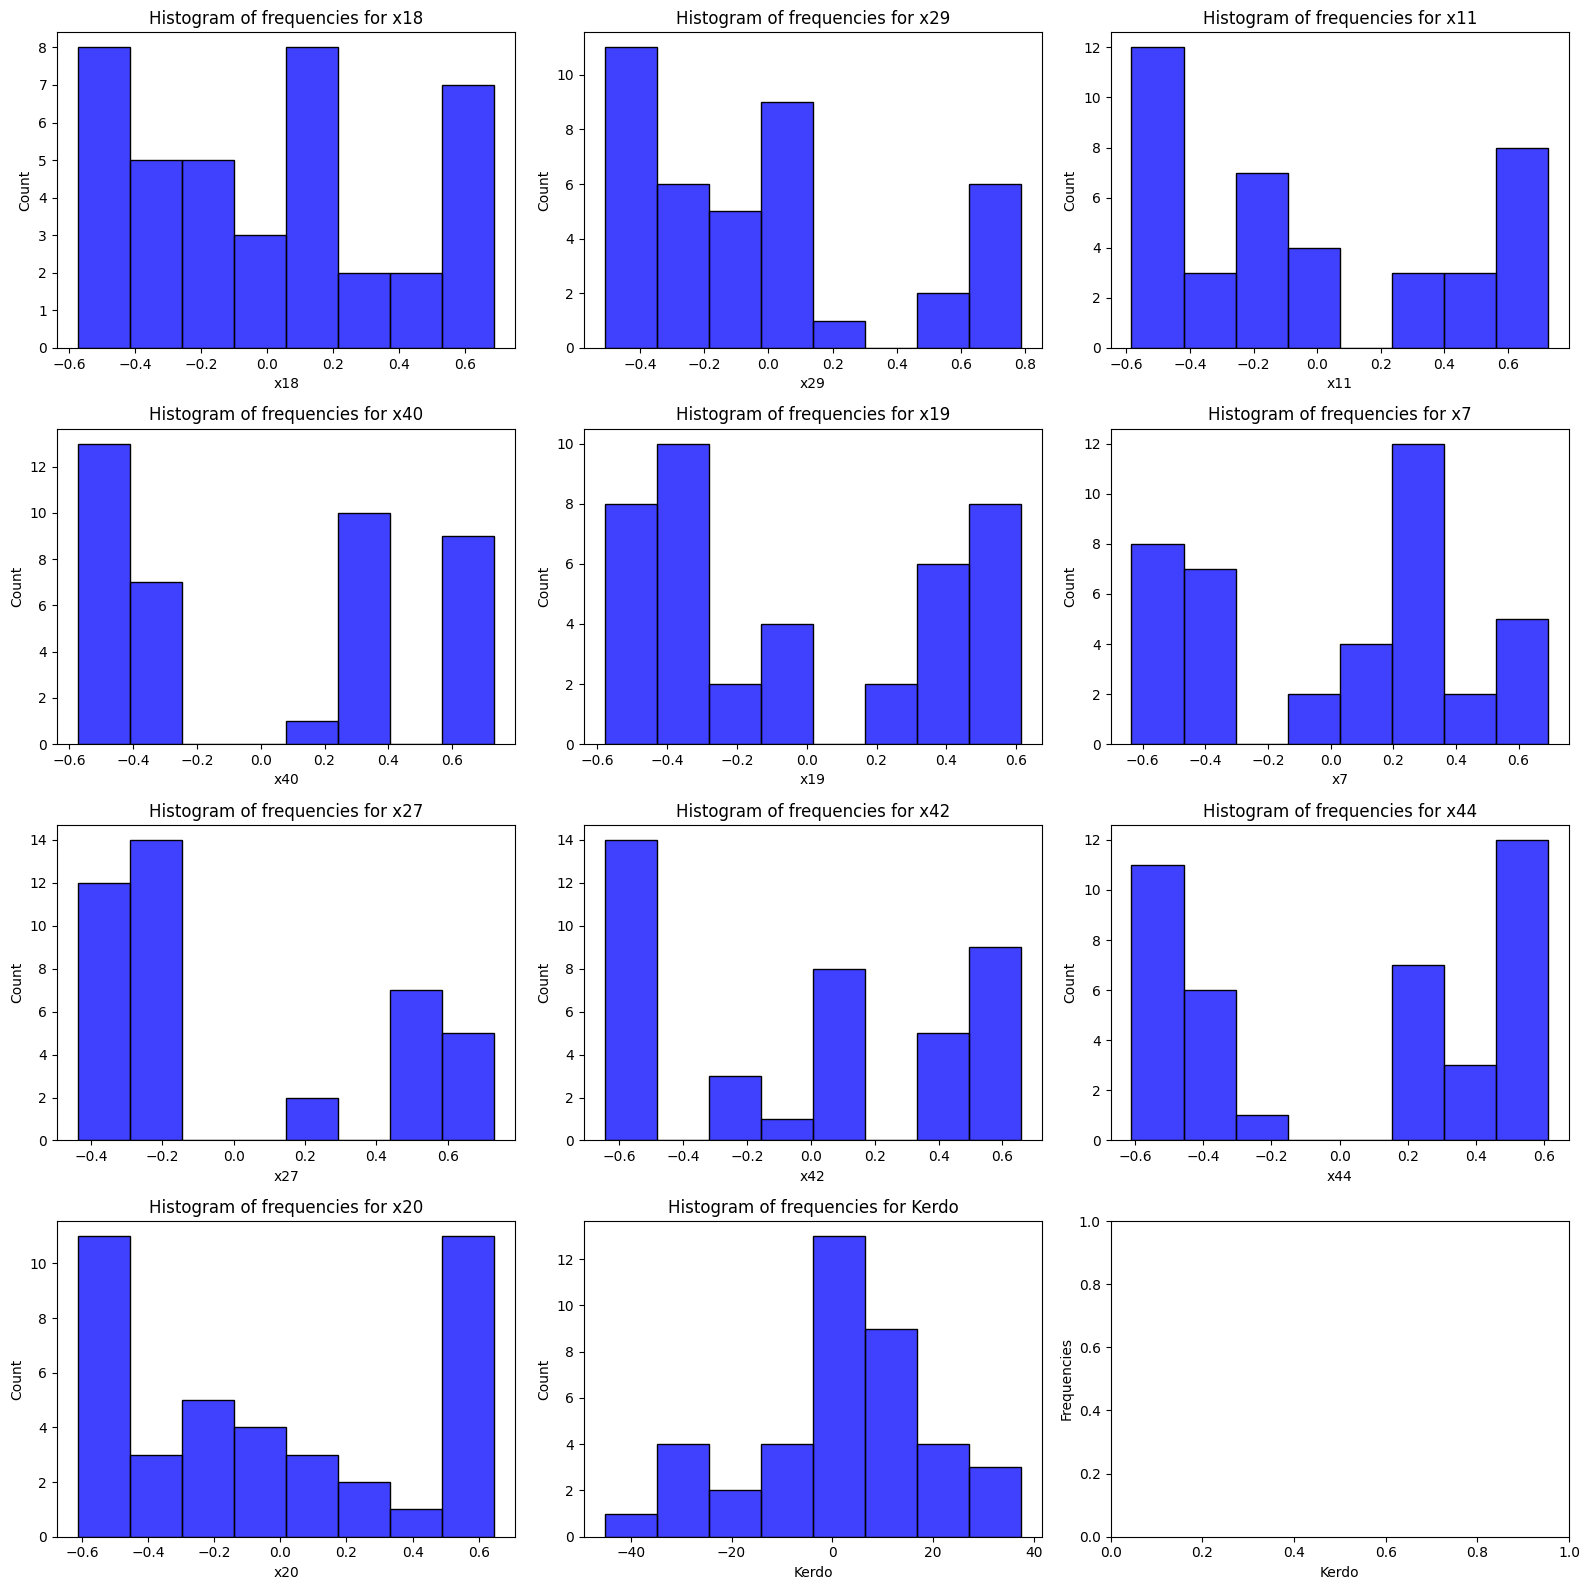

In [118]:
hist_frequencies(dataset, bins = 8)

### 3) Preprocessing

In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [120]:
x = dataset.loc[:, dataset.columns!= "Kerdo"]
y = dataset["Kerdo"].values

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=10, random_state=0)

In [122]:
# check dimensionality of each subset of data
print("Dimensions in x-train: ", x_train.shape)
print("Dimensions in y-train: ", y_train.shape)
print("Dimensions in x-test: ", x_test.shape)
print("Dimensions in y-test: ", y_test.shape)

Dimensions in x-train:  (30, 10)
Dimensions in y-train:  (30,)
Dimensions in x-test:  (10, 10)
Dimensions in y-test:  (10,)


In [123]:
# transformer will learn only from training data
transformer = StandardScaler()
transformer.fit(x_train)

StandardScaler()

In [124]:
# transformer will apply in the train and test data
x_train = transformer.transform(x_train)
x_test = transformer.transform(x_test)

In [125]:
# convert data to Pytorch tensor data structure
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [126]:
# Create DataLoaders for batch-stochastic gradient descendent
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

### 4) Build Model Architecture

In [127]:
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn as nn
import torch.optim as optim

In [128]:
# pytorch class to define regressor architecture
class RegressionNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_layers, activation_func):
        super(RegressionNeuralNet, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_layers
        self.activation_dict = {
            "relu": nn.ReLU(),
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh()
        }

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(in_features=layer_sizes[i], out_features=layer_sizes[i+1])) #linear comb
            layers.append(self.activation_dict[activation_func])    # activation function
        layers.append(nn.Linear(in_features=layer_sizes[-1], out_features=1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [129]:
# define list of experiments
experiments = [
    {'hidden_layers': [8, 4, 2], 'activation': 'relu'},
    {'hidden_layers': [8, 4], 'activation': 'relu'},
    {'hidden_layers': [8, 4, 2], 'activation': 'sigmoid'},
    {'hidden_layers': [8, 4], 'activation': 'sigmoid'},
    {'hidden_layers': [8, 4, 2], 'activation': 'tanh'},
    {'hidden_layers': [8, 4], 'activation': 'tanh'},
]

### 5) Training / Validation

In [ ]:
# Define the training function
def train_model(model, train_dataset, test_dataset, num_epochs=1000, patience=50):
    criterion = nn.MSELoss()    #loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
    train_losses = []
    test_losses = []
    val_rmse = []
    val_r2 = []

    x_train, y_train = train_dataset.tensors
    x_test, y_test = test_dataset.tensors

    best_loss = float('inf')
    patience_count = 0
    best_model_state = None

    # for each iteration
    for epoch in range(num_epochs):
        # training
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()        
        train_losses.append(loss.item())

        # validation
        model.eval()
        with torch.no_grad():            
            outputs = model(x_test)
            loss = criterion(outputs, y_test)
            test_losses.append(loss.item())

            # calulate validation metrics
            y_true_val = y_test.numpy()
            y_pred_val = outputs.numpy()
            val_rmse.append(np.sqrt(mean_squared_error(y_true_val, y_pred_val)))
            val_r2.append(r2_score(y_true_val, y_pred_val))
        
        # Early stopping
        if test_losses[-1] < best_loss:
            best_loss = test_losses[-1]
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break
        
    return train_losses, test_losses, val_rmse, val_r2

In [131]:
def run_training(input_size, experiments, train_dataset, test_dataset, x_test_tensor, y_test):

    experiment_results = []

    for experiment in experiments:
        print(f"Run experiment with hidden layers: {experiment['hidden_layers']}, activation: {experiment['activation']}")

        model = RegressionNeuralNet(input_size=input_size,
                                    hidden_layers=experiment['hidden_layers'],
                                    activation_func=experiment['activation'])
        
        train_losses, test_losses, val_rmse, val_r2 = train_model(model, train_dataset, test_dataset)

        # testing        
        model.eval()
        with torch.no_grad():
            y_pred = model(x_test_tensor)
        
        # calculate metrics for model quality
        y_pred_test = y_pred.numpy()
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_r2 = r2_score(y_test, y_pred_test)
        print(f"Mean Squared Error: {test_rmse:.4f}")
        print(f"R^2: {test_r2:.4f}")

        experiment_results.append({
            'experiment': experiment,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        })

    return experiment_results

In [132]:
# run the training/test process
exp_results = run_training(x_train.shape[1], experiments, train_dataset, test_dataset, x_test_tensor, y_test)

Run experiment with hidden layers: [8, 4, 2], activation: relu
Early stopping at epoch 51
Mean Squared Error: 21.1553
R^2: -0.0149
Run experiment with hidden layers: [8, 4], activation: relu
Early stopping at epoch 51
Mean Squared Error: 23.1129
R^2: -0.2115
Run experiment with hidden layers: [8, 4, 2], activation: sigmoid
Early stopping at epoch 51
Mean Squared Error: 21.3627
R^2: -0.0349
Run experiment with hidden layers: [8, 4], activation: sigmoid
Early stopping at epoch 51
Mean Squared Error: 21.3235
R^2: -0.0311
Run experiment with hidden layers: [8, 4, 2], activation: tanh
Early stopping at epoch 255
Mean Squared Error: 20.4999
R^2: 0.0470
Run experiment with hidden layers: [8, 4], activation: tanh
Early stopping at epoch 74
Mean Squared Error: 21.3187
R^2: -0.0307


### 6) Monitoring Results

In [133]:
def monitoring_results(experiment_results):

    # Plotting the results
    fig, axes = plt.subplots(4, 1, figsize=(10, 25))

    # Plot train and test loss by epoch for each experiment
    for result in experiment_results:
        experiment = result['experiment']
        label = f"{experiment['hidden_layers']} layers, {experiment['activation']}"
        axes[0].plot(result['train_losses'], label=f"Train: {label}")
        axes[1].plot(result['test_losses'], label=f"Test: {label}")
        axes[2].plot(result['val_rmse'], label=f"RMSE: {label}")
        axes[3].plot(result['val_r2'], label=f"R²: {label}")
    
    # Training loss report
    axes[0].set_title('Training Loss by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Test loss report
    axes[1].set_title('Testing Loss by Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Validation RMSE report
    axes[2].set_title('Validation RMSE by Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('RMSE')
    axes[2].legend()

    # Validation R² report
    axes[3].set_title('Validation R² by Epoch')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('R²')
    axes[3].legend()

    # Create a new figure for bar plots
    fig_bar, axes_bar = plt.subplots(2, 1, figsize=(10, 12))

    # Experiment labels
    experiment_labels = [f"{result['experiment']['hidden_layers']} layers, {result['experiment']['activation']}" 
                        for result in experiment_results]

    # Plot final RMSE for each experiment
    final_rmses = [min(result['val_rmse']) for result in experiment_results]  # Use final epoch's RMSE
    bars_rmse = axes_bar[0].bar(experiment_labels, final_rmses)
    axes_bar[0].set_title('Final Validation RMSE by Experiment')
    axes_bar[0].set_xlabel('Experiment')
    axes_bar[0].set_ylabel('RMSE')
    axes_bar[0].set_ylim(0, max(final_rmses) * 1.1)
    axes_bar[0].set_xticks(range(len(experiment_labels)))
    axes_bar[0].set_xticklabels(experiment_labels, rotation=45, ha='right')

    # Annotate RMSE bars
    for bar in bars_rmse:
        yval = bar.get_height()
        axes_bar[0].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    # Plot final R² for each experiment
    final_r2s = [max(result['val_r2']) for result in experiment_results]  # Use final epoch's R²
    bars_r2 = axes_bar[1].bar(experiment_labels, final_r2s)
    axes_bar[1].set_title('Final Validation R² by Experiment')
    axes_bar[1].set_xlabel('Experiment')
    axes_bar[1].set_ylabel('R²')
    axes_bar[1].set_ylim(0, 1)
    axes_bar[1].set_xticks(range(len(experiment_labels)))
    axes_bar[1].set_xticklabels(experiment_labels, rotation=45, ha='right')

    # Annotate R² bars
    for bar in bars_r2:
        yval = bar.get_height()
        axes_bar[1].text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

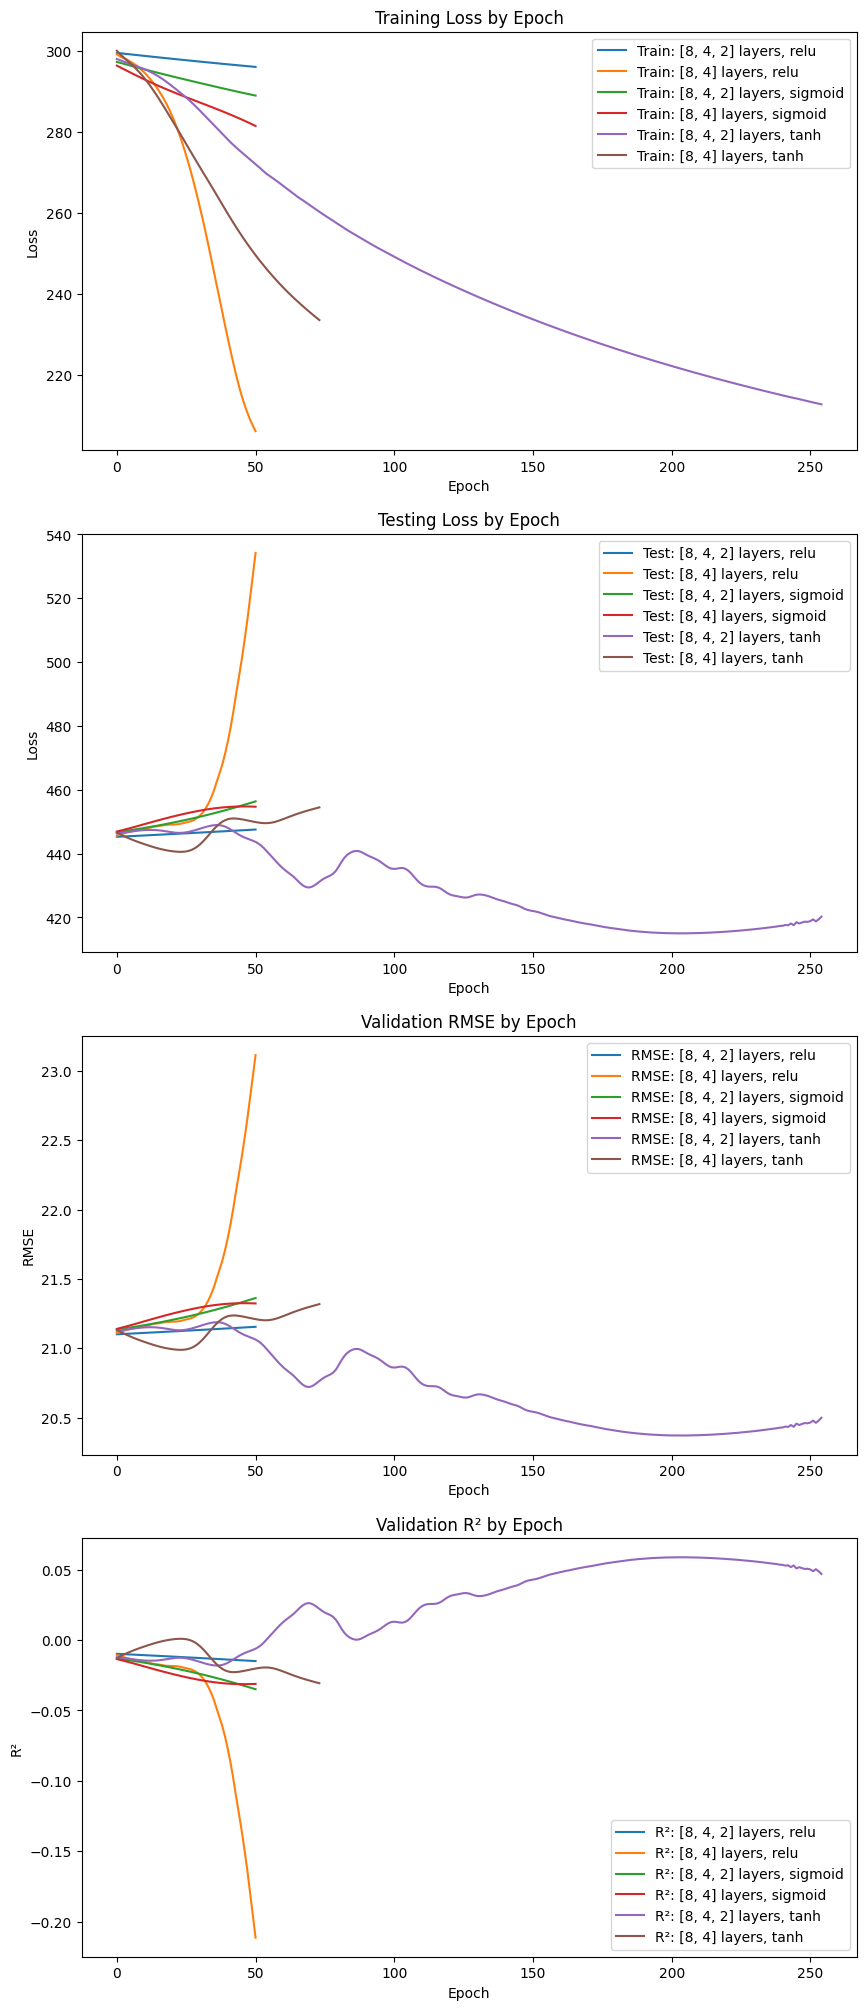

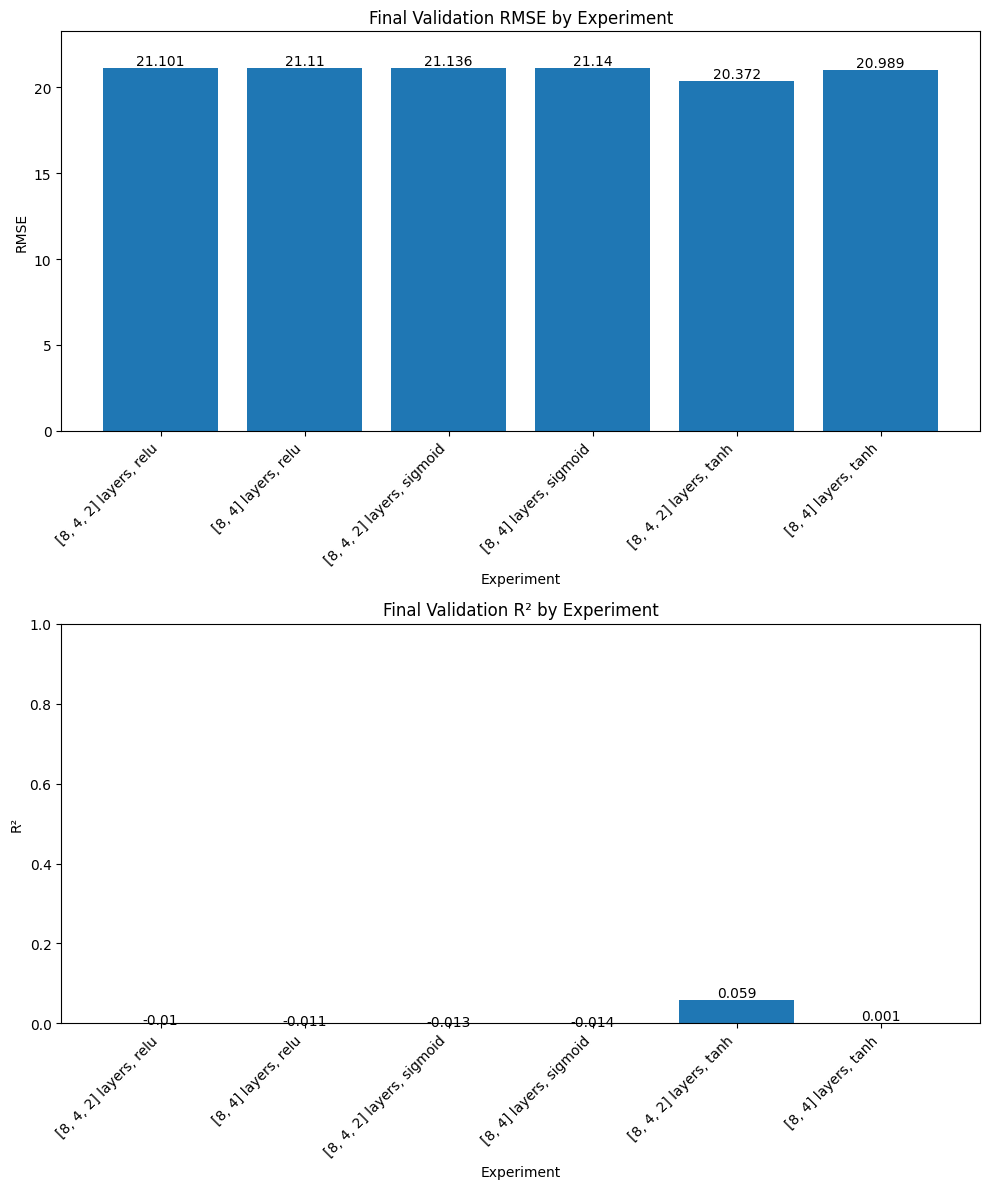

In [134]:
monitoring_results(exp_results)